# Incêndios e Área desmatada na Amazônia
Um notebook sobre __regressão linear__

> ### Hipótese:
> Incêndios são um fator relevante no desmatamento da Amazônia

![incendios](./dados/incendios.jpg)

## 1. Conjuntos de dados
### 1.1. Desmatamento
* Programa [DETER](http://www.obt.inpe.br/OBT/assuntos/programas/amazonia/deter)
* Programa [PRODES](http://www.obt.inpe.br/OBT/assuntos/programas/amazonia/prodes)

http://terrabrasilis.dpi.inpe.br/en/home-page/

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import linregress
%matplotlib inline

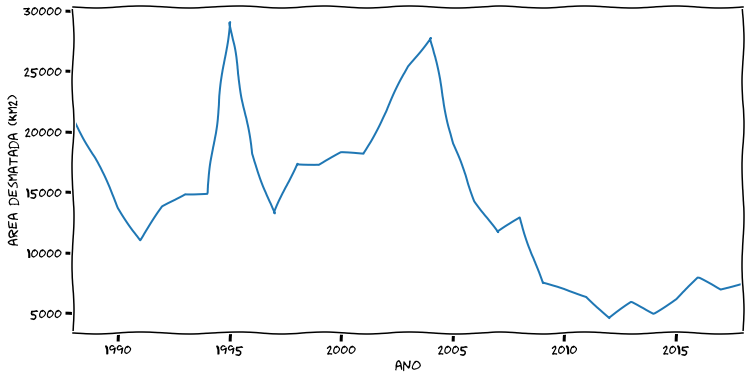

In [2]:
df_prodes = pd.read_csv("./dados/taxa_desmatamento_prodes.csv")
df_prodes = df_prodes.pivot_table(values="area", index="ano", columns="uf")
df_prodes["desmatamento"] = df_prodes.sum(axis=1)

# Todo o código abaixo de `with plt.xkcd()` é para plotar gráficos. Pode Ignorar.
with plt.xkcd():
    ax = plt.axes()
    ax.set_ylabel("area desmatada (km2)")
    df_prodes["desmatamento"].plot(figsize=(12, 6), ax=ax)

 ### 2004 - [Plano de Ação para Prevenção e Controle do Desmatamento na Amazônia Legal (PPCDAm)](http://redd.mma.gov.br/pt/acompanhamento-e-a-analise-de-impacto-das-politicas-publicas/ppcdam)
 
![title](dados/PPCDAm.jpg)

### 1.2. Incêndios
* [INPE](http://queimadas.dgi.inpe.br/queimadas/portal-static/estatisticas_estados/)

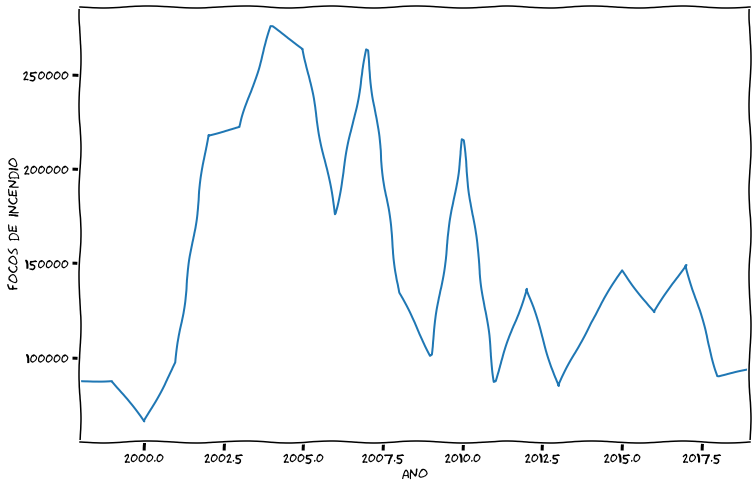

In [3]:
df_incendios = pd.read_csv("./dados/incendios_amazonia.csv")
df_incendios = df_incendios.set_index("Ano").rename(columns={"Total": "incendios"})
df_incendios
df_incendios["incendios"] = df_incendios["incendios"].astype(int)

with plt.xkcd():
    ax = plt.axes()
    ax.set_ylabel("focos de incendio")
    df_incendios["incendios"].plot(figsize=(12, 8), ax=ax)

### 1.3. Desmatamento em função dos focos de incêndio

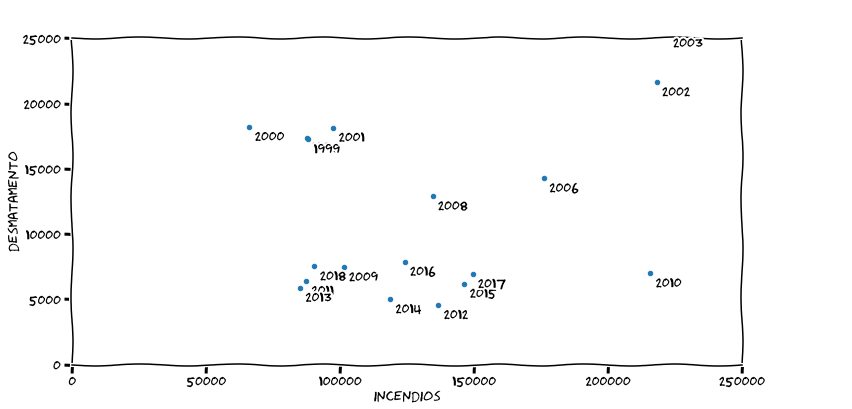

In [4]:
df = df_prodes[["desmatamento"]].join(df_incendios[["incendios"]]).dropna().astype(int)

with plt.xkcd():
    ax = df.plot.scatter("incendios", "desmatamento", figsize=(12, 6), xlim=(0, 250000), ylim=(0, 25000))
    for i in df.index:
        ax.annotate(i, (df["incendios"][i]+2000, df["desmatamento"][i]-1000))

## 2. Regressão Linear com SciPy
O objetivo da regressão linear é encontrar a reta que melhor representa o conjunto de dados. Isso equivale a correlacionar a variável dependente no eixo $x$ com a variável independente no eixo $y$.

### \begin{equation*}
y  = \alpha + \beta X +\varepsilon \\
y  = \alpha + (\beta_0 x_0 + \beta_1 x_1 + ... + \beta_n x_n) +\varepsilon\\
\end{equation*}

#### Caso 2D:
### \begin{equation*}
y  = \alpha + \beta x\\
y  = \text{intercept} + \text{slope}.x\\
\end{equation*}

O parâmetro $\alpha$ corresponde à inclinação da reta e o parâmetro $\beta$ corresponde ao ponto de interceptação da reta no eixo $y$.

Vamos calcular a inclinação e o ponto de interceptação usando a biblioteca `SciPy`, usando a função `linregress`

In [5]:
help(linregress)

Help on function linregress in module scipy.stats._stats_mstats_common:

linregress(x, y=None)
    Calculate a linear least-squares regression for two sets of measurements.
    
    Parameters
    ----------
    x, y : array_like
        Two sets of measurements.  Both arrays should have the same length.
        If only x is given (and y=None), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension.
    
    Returns
    -------
    slope : float
        slope of the regression line
    intercept : float
        intercept of the regression line
    rvalue : float
        correlation coefficient
    pvalue : float
        two-sided p-value for a hypothesis test whose null hypothesis is
        that the slope is zero, using Wald Test with t-distribution of
        the test statistic.
    stderr : float
        Standard error of the estimated gradient.
    
  

## 2.1 Dados com $\varepsilon = 0$ 
### \begin{equation*}
y  = \alpha + \beta X +\varepsilon \\
\end{equation*}

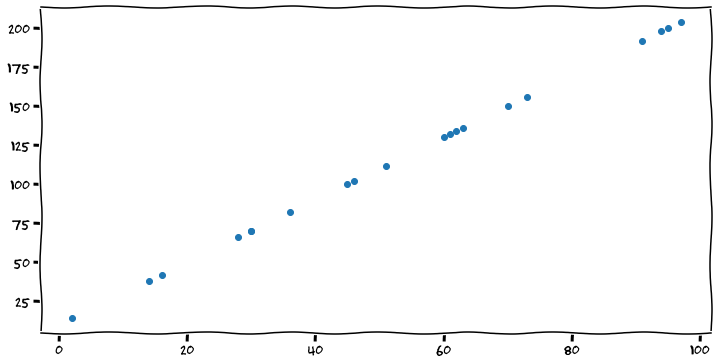

In [6]:
np.random.seed(666)
beta = 2
alpha = 10
n = 20
X = sorted(np.random.randint(0, 100, n))
Y = [alpha + beta*x for x in X]
    
with plt.xkcd():
    fig = plt.figure(figsize=(12,6))
    plt.scatter(X, Y)

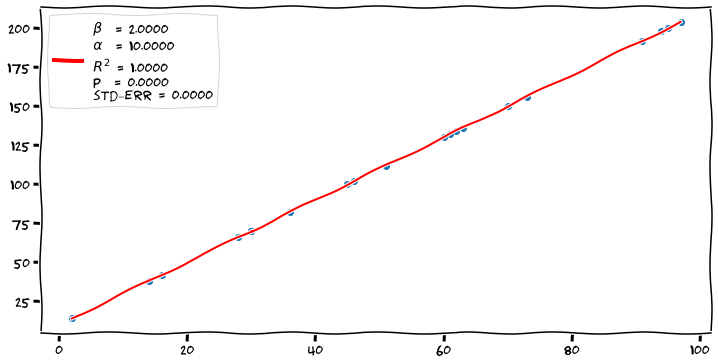

In [7]:
def line(slope, intercept, X):
        return np.add(np.multiply(slope, X), intercept)

slope, intercept, r_value, p_value, std_err = linregress(X, Y)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,6))
    plt.scatter(X, Y)
    plt.plot(X, line(slope, intercept, X), color="red")
    ax.legend(
        [Line2D([0], [0], color="red", lw=4)], 
        ['$\\beta$  = {0:.4f}\n$\\alpha$  = {1:.4f}\n$R^2$ = {2:.4f}\np  = {3:.4f}\nstd_err = {4:.4f}'.format(
            slope, intercept, r_value**2, p_value, std_err)])

Esse é o caso no qual a variável independente explica perfeitamente a variável independente.

#### $R^2$ => Coeficiente de determinação
O coeficiente de determinação corresponde à proporção da variância na variável dependente que pode ser explicada pela variável independente.

#### valor p => Probabilidade de significância
Probabilidade de obter os dados sob a _hipótese nula_.

#### std err => Erro padrão
Variação da amostra em relação à média da população.
## 2.2 Dados com $\varepsilon$ pequeno

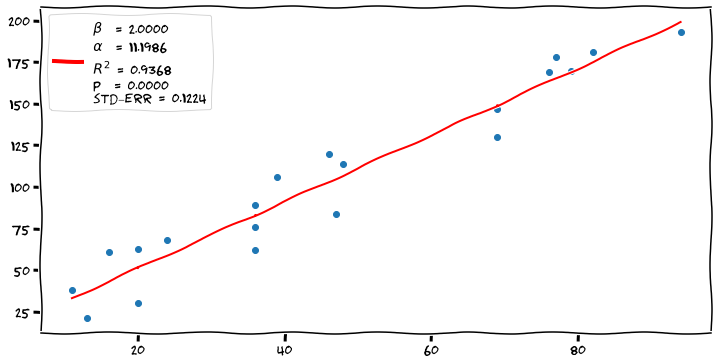

In [8]:
beta = 2
alpha = 10
epsilon = 20
n = 20
X = sorted(np.random.randint(0, 100, n))
Y = [alpha + beta*x + np.random.randint(-epsilon, epsilon) for x in X]
    
slope, intercept, r_value, p_value, std_err = linregress(X, Y)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,6))
    plt.scatter(X, Y)
    plt.plot(X, line(slope, intercept, X), color="red")
    ax.legend(
        [Line2D([0], [0], color="red", lw=4)], 
        ['$\\beta$  = {0:.4f}\n$\\alpha$  = {1:.4f}\n$R^2$ = {2:.4f}\np  = {3:.4f}\nstd_err = {4:.4f}'.format(
            slope, intercept, r_value**2, p_value, std_err)])

As perturbações $\varepsilon$ diminuem a certeza da regressão.
## 2.3 Dados com $\varepsilon$ grande

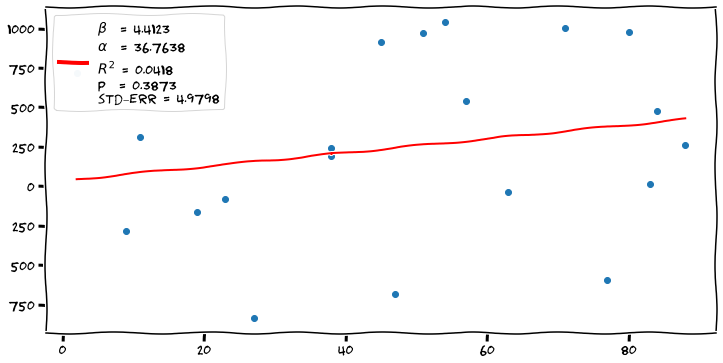

In [9]:
beta = 2
alpha = 10
epsilon = 1000
n = 20
X = sorted(np.random.randint(0, 100, n))
Y = [alpha + beta*x + np.random.randint(-epsilon, epsilon) for x in X]

slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,6))
    plt.scatter(X, Y)
    plt.plot(X, line(slope, intercept, X), color="red")
    ax.legend(
        [Line2D([0], [0], color="red", lw=4)], 
        ['$\\beta$  = {0:.4f}\n$\\alpha$  = {1:.4f}\n$R^2$ = {2:.4f}\np  = {3:.4f}\nstd_err = {4:.4f}'.format(
            slope, intercept, r_value**2, p_value, std_err)])

Não é possível determinar uma correlação entre as variáveis.
## 2.4 Dados com $n$ grande

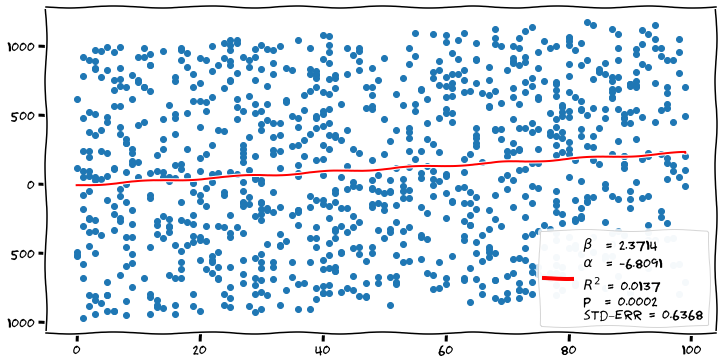

In [10]:
beta = 2
alpha = 10
epsilon = 1000
n = 1000
X = sorted(np.random.randint(0, 100, n))
Y = [alpha + beta*x + np.random.randint(-epsilon, epsilon) for x in X]

slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,6))
    plt.scatter(X, Y)
    plt.plot(X, line(slope, intercept, X), color="red")
    ax.legend(
        [Line2D([0], [0], color="red", lw=4)], 
        ['$\\beta$  = {0:.4f}\n$\\alpha$  = {1:.4f}\n$R^2$ = {2:.4f}\np  = {3:.4f}\nstd_err = {4:.4f}'.format(
            slope, intercept, r_value**2, p_value, std_err)])

Podemos determinar correlações fracas com bastante certeza, se coletarmos amostras suficientes.
## 2.5 Dados aleatórios

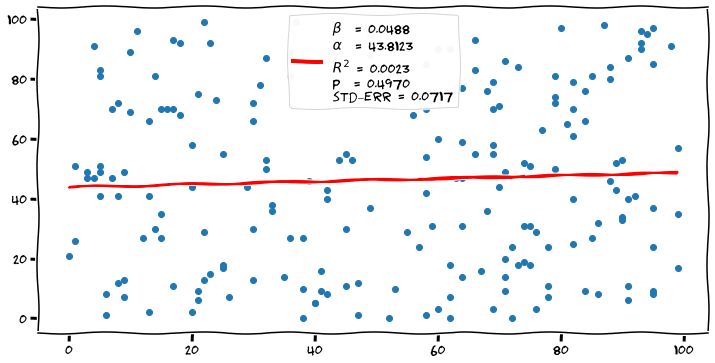

In [11]:
n = 200
X = np.random.randint(0, 100, n)
Y = np.random.randint(0, 100, n)

slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,6))
    plt.scatter(X, Y)
    plt.plot(X, line(slope, intercept, X), color="red")
    ax.legend(
        [Line2D([0], [0], color="red", lw=4)], 
        ['$\\beta$  = {0:.4f}\n$\\alpha$  = {1:.4f}\n$R^2$ = {2:.4f}\np  = {3:.4f}\nstd_err = {4:.4f}'.format(
            slope, intercept, r_value**2, p_value, std_err)])

No caso de dados aleatórios, não é possível determinar correlações entre eles.

## 3. Mínimos Quadrados
O método dos mínimos quadrados determina os parâmetros $\alpha$ e $\beta$ minimizando a soma do quadrado dos residuais do conjunto de dados.

### \begin{equation*}
\varepsilon_i  = y_i - \alpha - \beta x_i \text{ (residual)}\\
\min _{\alpha ,\,\beta }Q(\alpha ,\beta ),\quad {\text{para }}Q(\alpha ,\beta )=\sum _{i=1}^{n}{\widehat {\varepsilon }}_{i}^{\,2}=\sum _{i=1}^{n}(y_{i}-\alpha -\beta x_{i})^{2}\
\end{equation*}

Para minimizar o residual:
### \begin{equation*}
\frac{d(\varepsilon^2)}{d\alpha} = 0\\
\frac{d(\varepsilon^2)}{d\beta} = 0\\
\end{equation*}

Portanto, para o coeficiente $\alpha$:
### \begin{equation*}
-2\sum ^{n}y_{i}-\alpha -\beta x_{i}  = 0 \\
\sum^{n}{(y_{i})}-n\alpha -\beta \sum^n{(x_{i})}  = 0 \\
\alpha  = \sum^{n}{\frac{y_{i}}{n}} - \beta\sum^{n}{\frac{x_{i}}{n}} \\
\alpha  = \bar{y} - \beta \bar{x}
\end{equation*}

Para o coeficiente $\beta$:
### \begin{equation*}
-2\sum ^{n}(y_{i}-\alpha -\beta x_{i})x_i  = 0 \\
\sum^{n}{y_{i}x_i}-n\alpha \sum^n{x_i} -\beta \sum^n{x_{i}^2}  = 0 \\
\sum^{n}{y_{i}x_i}-n\bar{y} \sum^n{x_i} + n\beta \bar{x} \sum^n{x_i} -\beta \sum^n{x_{i}^2}  = 0 \\
\sum^{n}{y_{i}x_i}-n\bar{y} \bar{x} + n\beta {\bar{x}}^2 -\beta \sum^n{x_{i}^2}  = 0 \\
\beta ({\sum^n{x_{i}^2}} - n\bar{x}^2)  = \sum^{n}{y_{i}x_i} - n\bar{y} \bar{x}\\
\\
\beta = \frac{\sum^n({y_{i}x_i}) - n\bar{y} \bar{x}}{\sum^n({x_{i}^2}) - {n\bar{x}}^2} \\
\end{equation*}

### Exemplo:

X: [16, 37, 42, 76, 89] 
Y: [8, 97, 61, 119, 229]


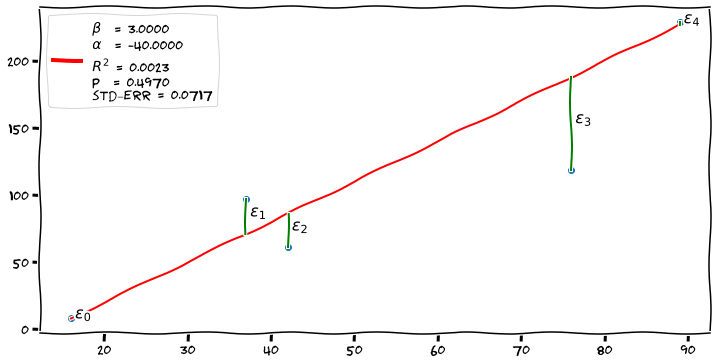

In [12]:
beta = 2
alpha = 10
epsilon = 50
n = 5
X = sorted(np.random.randint(0, 100, n))
Y = [alpha + beta*x + np.random.randint(-epsilon, epsilon) for x in X]
print("X:", X, "\nY:", Y)
    
with plt.xkcd():
    slope = 3
    intercept = -40
    fig, ax = plt.subplots(figsize=(12,6))
    plt.scatter(X, Y)
    plt.plot(X, line(slope, intercept, X), color="red")
    ax.legend(
        [Line2D([0], [0], color="red", lw=4)], 
        ['$\\beta$  = {0:.4f}\n$\\alpha$  = {1:.4f}\n$R^2$ = {2:.4f}\np  = {3:.4f}\nstd_err = {4:.4f}'.format(
            slope, intercept, r_value**2, p_value, std_err)])
    for i, (x, y) in enumerate(zip(X, Y)):
        l = line(slope, intercept, x)
        plt.plot([x, x], [y, l], color="green")
        plt.text(x+0.5, (y+l)/2, "$\epsilon_{}$".format(i), {"size": 16})

### 3.1. Calculando $\bar{x}$ e $\bar{y}$

In [13]:
X_bar = np.mean(X)
Y_bar = np.mean(Y)
print("X_bar:", X_bar, "\nY_bar:", Y_bar)

X_bar: 52.0 
Y_bar: 102.8


### 3.2 Calculando $\sum^n({y_{i}x_i})$ e $\sum^n({x_i^2})$

In [14]:
XY = np.dot(X, Y)
X2 = np.dot(X, X)
print("XY:", XY, "\nX2:", X2)

XY: 35704 
X2: 17086


### 3.3 Calculando $\beta$:
### \begin{equation*}
\beta = \frac{\sum^n({y_{i}x_i}) - n\bar{y} \bar{x}}{\sum^n({x_{i}^2}) - {n\bar{x}}^2} \\
\end{equation*}

In [15]:
B = (XY - n*X_bar*Y_bar)/(X2 - n*X_bar**2)
print("beta:", B)

beta: 2.517106001121705


### 3.4 Calculando $\alpha$:
### \begin{equation*}
\alpha  = \bar{y} - \beta \bar{x}
\end{equation*}

In [16]:
A = Y_bar - B*X_bar
print("alpha:", A)

alpha: -28.08951205832865


### 3.4 Calculando $\varepsilon^2$:
### \begin{equation*}
\varepsilon^{\,2}=\sum _{i=1}^{n}(y_{i}-\alpha -\beta x_{i})^{2}\
\end{equation*}

In [17]:
E2 = ((Y - line(B, A, X))**2).sum()
print("epsilon^2:", E2)

epsilon^2: 4363.256533931578


### 3.5 Calculando $R^2$
### \begin{equation*}
R^2  = 1 - \frac{\epsilon^2}{\sum^n{(y_i - \bar{y})^2}}
\end{equation*}


In [18]:
R2 = 1 - E2/np.dot((Y-Y_bar), (Y-Y_bar))
print("R^2:", R2)

R^2: 0.8381389284361802


### 3.6 Comparando com o SciPy

slope: 2.517106001121705 
intercept: -28.08951205832865 
r^2: 0.8381389284361801 
p_value: 0.029109972701393726 
std_err 0.6386370013347811


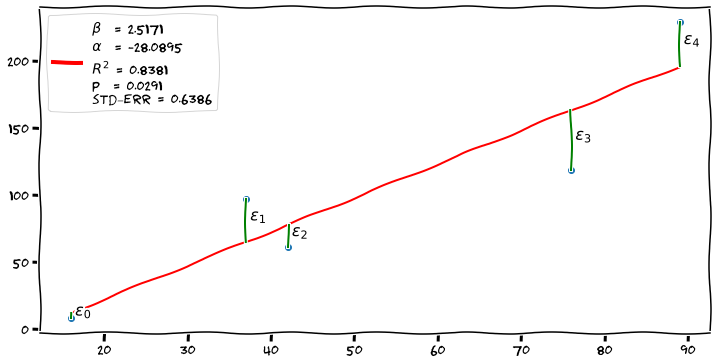

In [19]:
slope, intercept, r_value, p_value, std_err = linregress(X, Y)
print("slope:", slope, "\nintercept:", intercept, "\nr^2:", r_value**2, "\np_value:", p_value, "\nstd_err", std_err)
    
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,6))
    plt.scatter(X, Y)
    plt.plot(X, line(slope, intercept, X), color="red")
    ax.legend(
        [Line2D([0], [0], color="red", lw=4)], 
        ['$\\beta$  = {0:.4f}\n$\\alpha$  = {1:.4f}\n$R^2$ = {2:.4f}\np  = {3:.4f}\nstd_err = {4:.4f}'.format(
            slope, intercept, r_value**2, p_value, std_err)])
    for i, (x, y) in enumerate(zip(X, Y)):
        l = line(slope, intercept, x)
        plt.plot([x, x], [y, l], color="green")
        plt.text(x+0.5, (y+l)/2, "$\epsilon_{}$".format(i), {"size": 16})

Ambos os coeficientes $\alpha$ e $\beta$ foram determinados corretamente, além do coeficiente de determinação $R^2$.
### 3.7 Visualização no espaço dos parâmetros

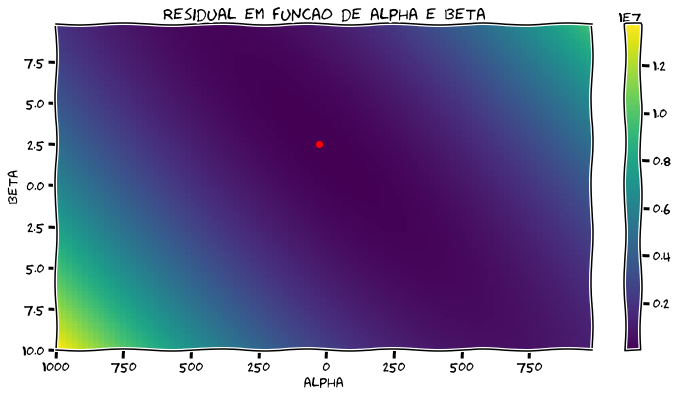

In [20]:
with plt.xkcd():
    As = np.arange(-1000, 1000, 20)
    Bs = np.arange(-10, 10, 0.2)
    Es = []
    for b in Bs:
        Es.append([])
        for a in As:
            Es[-1].append(((Y - line(b, a, X))**2).sum())
    Es = np.array(Es)
    As, Bs = np.meshgrid(As, Bs)
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes()
    ax.set_ylabel("beta")
    ax.set_xlabel("alpha")
    ax.set_title("Residual em funcao de alpha e beta")
    plt.pcolormesh(As, Bs, Es)
    plt.colorbar()
    plt.scatter([intercept], [slope], color="red")

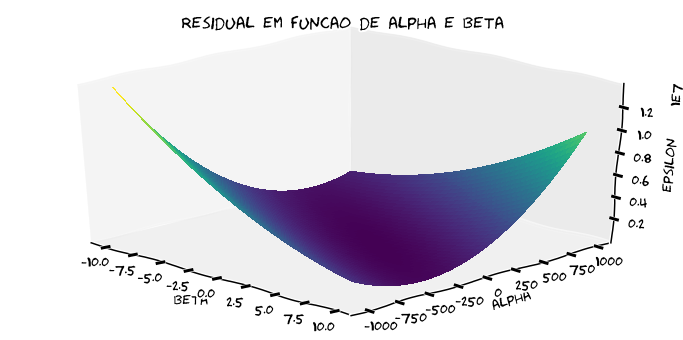

In [21]:
with plt.xkcd():
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca(projection='3d')
    ax.plot_surface(Bs, As, Es, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax.view_init(30, -45)
    ax.set_xlabel("beta")
    ax.set_ylabel("alpha")
    ax.set_zlabel("epsilon")
    ax.set_title("Residual em funcao de alpha e beta")
    plt.show()

## 4. Aplicando regressão linear no dataset:

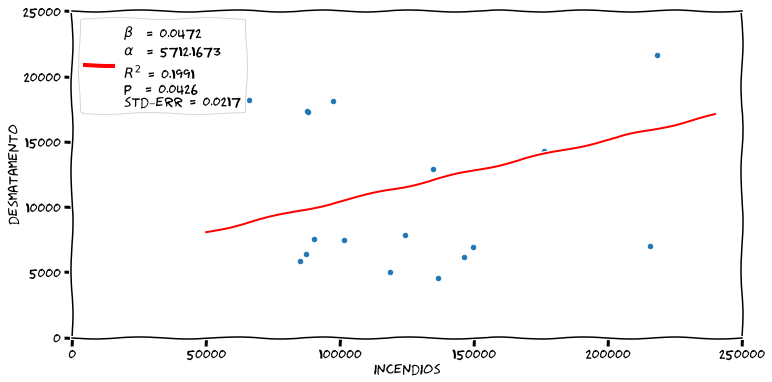

In [22]:
slope, intercept, r_value, p_value, std_err = linregress(df["incendios"].values, df["desmatamento"].values)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,6))
    X = np.array(range(50000, 250000, 10000))
    Y = line(slope, intercept, X)
    plt.plot(X, line(slope, intercept, X), color="red")
    ax.plot(X, Y, color="red")
    df.plot.scatter("incendios", "desmatamento", figsize=(12, 6), xlim=(0, 250000), ylim=(0, 25000), ax=ax)
    ax.legend(
        [Line2D([0], [0], color="red", lw=4)], 
        ['$\\beta$  = {0:.4f}\n$\\alpha$  = {1:.4f}\n$R^2$ = {2:.4f}\np  = {3:.4f}\nstd_err = {4:.4f}'.format(
            slope, intercept, r_value**2, p_value, std_err)])

> # ~20% do desmatamento na Amazônia Legal pode ser explicado pelos incêndios com uma confiança maior que 95%.

![queimada](./dados/incendios_final.jpg)
# Obrigado!